<a href="https://colab.research.google.com/github/CharlesPrado23/Notebooks/blob/main/Semana11/Clustering.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# The Battle of Neighborhoods

In [1]:
#!pip install beautifulsoup4
#!pip install lxml
import requests # library to handle requests
import pandas as pd # library for data analsysis
import numpy as np # library to handle data in a vectorized manner
import random # library for random number generation  

#!conda install -c conda-forge geopy --yes 
from geopy.geocoders import Nominatim # module to convert an address into latitude and longitude values

# libraries for displaying images
from IPython.display import Image 
from IPython.core.display import HTML 


from IPython.display import display_html
import pandas as pd
import numpy as np
    
# tranforming json file into a pandas dataframe library
from pandas.io.json import json_normalize

!conda install -c conda-forge folium=0.5.0 --yes
import folium # plotting library
from bs4 import BeautifulSoup
from sklearn.cluster import KMeans
import matplotlib.cm as cm
import matplotlib.colors as colors

print('Folium installed')
print('Libraries imported.')

/bin/bash: conda: command not found
Folium installed
Libraries imported.


## Scraping the Wikipedia page for the table of postal codes of Canada


In [2]:
source = requests.get('https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M').text

soup = BeautifulSoup(source, 'html5lib')

postal_codes_dict = {} # initialize an empty dictionary to save the data in
for table_cell in soup.find_all('td'):
    try:
        postal_code = table_cell.p.b.text # get the postal code
        postal_code_investigate = table_cell.span.text
        neighborhoods_data = table_cell.span.text # get the rest of the data in the cell
        borough = neighborhoods_data.split('(')[0] # get the borough in the cell
        
        # if the cell is not assigned then ignore it
        if neighborhoods_data == 'Not assigned':
            neighborhoods = []
        # else process the data and add it to the dictionary
        else:
            postal_codes_dict[postal_code] = {}
            
            try:
                neighborhoods = neighborhoods_data.split('(')[1]
            
                # remove parantheses from neighborhoods string
                neighborhoods = neighborhoods.replace('(', ' ')
                neighborhoods = neighborhoods.replace(')', ' ')

                neighborhoods_names = neighborhoods.split('/')
                neighborhoods_clean = ', '.join([name.strip() for name in neighborhoods_names])
            except:
                borough = borough.strip('\n')
                neighborhoods_clean = borough
 
            # add borough and neighborhood to dictionary
            postal_codes_dict[postal_code]['borough'] = borough
            postal_codes_dict[postal_code]['neighborhoods'] = neighborhoods_clean
    except:
        pass
    
# create an empty dataframe
columns = ['PostalCode', 'Borough', 'Neighborhood']
toronto_data = pd.DataFrame(columns=columns)
toronto_data

# populate dataframe with data from dictionary
for ind, postal_code in enumerate(postal_codes_dict):
    borough = postal_codes_dict[postal_code]['borough']
    neighborhood = postal_codes_dict[postal_code]['neighborhoods']
    toronto_data = toronto_data.append({"PostalCode": postal_code, 
                                        "Borough": borough, 
                                        "Neighborhood": neighborhood},
                                        ignore_index=True)

# print number of rows of dataframe
toronto_data.shape[0]

103

In [3]:
df = toronto_data
df.head()

,PostalCode,Borough,Neighborhood
0,M3A,North York,Parkwoods
1,M4A,North York,Victoria Village
2,M5A,Downtown Toronto,"Regent Park, Harbourfront"
3,M6A,North York,"Lawrence Manor, Lawrence Heights"
4,M7A,Queen's Park,Ontario Provincial Government


## The html table is converted to Pandas DataFrame for cleaning and preprocessing.

## Data preprocessing and cleaning

In [4]:
# Dropping the rows where Borough is 'Not assigned'
df1 = df[df.Borough != 'Not assigned']

# Combining the neighbourhoods with same Postalcode
df2 = df1.groupby(['PostalCode','Borough'], sort=False).agg(', '.join)
df2.reset_index(inplace=True)

# Replacing the name of the neighbourhoods which are 'Not assigned' with names of Borough
df2['Neighborhood'] = np.where(df2['Neighborhood'] == 'Not assigned',df2['Borough'], df2['Neighborhood'])

df2

,PostalCode,Borough,Neighborhood
0,M3A,North York,Parkwoods
1,M4A,North York,Victoria Village
2,M5A,Downtown Toronto,"Regent Park, Harbourfront"
3,M6A,North York,"Lawrence Manor, Lawrence Heights"
4,M7A,Queen's Park,Ontario Provincial Government
...,...,...,...
98,M8X,Etobicoke,"The Kingsway, Montgomery Road, Old Mill North"
99,M4Y,Downtown Toronto,Church and Wellesley
100,M7Y,East TorontoBusiness reply mail Processing Cen...,Enclave of M4L
101,M8Y,Etobicoke,"Old Mill South, King's Mill Park, Sunnylea, Hu..."


In [5]:
# Shape DataFrame 
df2.shape

(103, 3)

##  Importing the csv file conatining the latitudes and longitudes for various neighbourhoods in Canada


In [6]:
lat_lon = pd.read_csv('https://cocl.us/Geospatial_data')
lat_lon.head()

,Postal Code,Latitude,Longitude
0,M1B,43.806686,-79.194353
1,M1C,43.784535,-79.160497
2,M1E,43.763573,-79.188711
3,M1G,43.770992,-79.216917
4,M1H,43.773136,-79.239476


## Merging the two tables for getting the Latitudes and Longitudes for various neighbourhoods in Canada

In [7]:
lat_lon.rename(columns={'Postal Code':'PostalCode'},inplace=True)
df3 = pd.merge(df2,lat_lon,on='PostalCode')
df3.head()

,PostalCode,Borough,Neighborhood,Latitude,Longitude
0,M3A,North York,Parkwoods,43.753259,-79.329656
1,M4A,North York,Victoria Village,43.725882,-79.315572
2,M5A,Downtown Toronto,"Regent Park, Harbourfront",43.654260,-79.360636
3,M6A,North York,"Lawrence Manor, Lawrence Heights",43.718518,-79.464763
4,M7A,Queen's Park,Ontario Provincial Government,43.662301,-79.389494


## Getting all the rows from the data frame which contains Toronto in their Borough.

In [8]:
df4 = df3[df3['Borough'].str.contains('Toronto',regex=False)]
df4.head()

,PostalCode,Borough,Neighborhood,Latitude,Longitude
2,M5A,Downtown Toronto,"Regent Park, Harbourfront",43.654260,-79.360636
9,M5B,Downtown Toronto,"Garden District, Ryerson",43.657162,-79.378937
15,M5C,Downtown Toronto,St. James Town,43.651494,-79.375418
19,M4E,East Toronto,The Beaches,43.676357,-79.293031
20,M5E,Downtown Toronto,Berczy Park,43.644771,-79.373306


## Visualizing all the Neighbourhoods of the above data frame using Folium

In [9]:
map_toronto = folium.Map(location=[43.651070,-79.347015],zoom_start=10)

for lat,lng,borough,neighbourhood in zip(df4['Latitude'],df4['Longitude'],df4['Borough'],df4['Neighborhood']):
    label = '{}, {}'.format(neighbourhood, borough)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
    [lat,lng],
    radius=5,
    popup=label,
    color='blue',
    fill=True,
    fill_color='#3186cc',
    fill_opacity=0.7,
    parse_html=False).add_to(map_toronto)
map_toronto

In [10]:
# Next, I am going to start utilizing the Foursquare API to explore the neighborhoods and segment them.
CLIENT_ID = '0WYKSJ5STW1VHCT2T13NRLAB3NVZY5BTIJGK05K50EXRCA1T' # Foursquare ID
CLIENT_SECRET = 'GGEUAQBUZ0U4YHFQ0QKBVFLHLDDW0A3LNYCYD1DJV0OY30SF' # Foursquare Secret
VERSION = '20180605' # Foursquare API version
LIMIT = 500
radius = 5000

print('Credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

Credentails:
CLIENT_ID: 0WYKSJ5STW1VHCT2T13NRLAB3NVZY5BTIJGK05K50EXRCA1T
CLIENT_SECRET:GGEUAQBUZ0U4YHFQ0QKBVFLHLDDW0A3LNYCYD1DJV0OY30SF


In [11]:
df4.iloc[0].Neighborhood # Get the neighborhood name

'Regent Park, Harbourfront'

In [12]:
# Get the neighborhoods' latitude and longitude values
neighborhood_latitude = df4.iloc[0].Latitude # neighborhood latitude value
neighborhood_longitude = df4.iloc[0].Longitude # neighborhood longitude value
neighborhood_name = df4.iloc[0].Neighborhood # neighborhood name

print('Latitude and longitude values of {} are {}, {}.'.format(neighborhood_name, 
                                                               neighborhood_latitude, 
                                                               neighborhood_longitude))

Latitude and longitude values of Regent Park, Harbourfront are 43.6542599, -79.3606359.


In [13]:
url = 'https://api.foursquare.com/v2/venues/explore?client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(CLIENT_ID, CLIENT_SECRET, VERSION, neighborhood_latitude, neighborhood_longitude, radius, LIMIT)
url

'https://api.foursquare.com/v2/venues/explore?client_id=0WYKSJ5STW1VHCT2T13NRLAB3NVZY5BTIJGK05K50EXRCA1T&client_secret=GGEUAQBUZ0U4YHFQ0QKBVFLHLDDW0A3LNYCYD1DJV0OY30SF&v=20180605&ll=43.6542599,-79.3606359&radius=5000&limit=500'

###  Send the GET request and examine the results

In [14]:

results = requests.get(url).json()
#results

### All the information is in the items key. Let's borrow the get_category_type function from the Foursquare lab.
### Function that extracts the category of the venue

In [15]:

def get_category_type(row):
    try:
        categories_list = row['categories']
    except:
        categories_list = row['venue.categories']
        
    if len(categories_list) == 0:
        return None
    else:
        return categories_list[0]['name']

In [16]:
venues = results['response']
#venues

In [17]:
# Clean the json and structure in into a pandas dataframe.
venues = results['response']['groups'][0]['items']
#venues = results['response']
    
nearby_venues = json_normalize(venues) # flatten JSON

# filter columns
filtered_columns = ['venue.name', 'venue.categories', 'venue.location.lat', 'venue.location.lng']
nearby_venues =nearby_venues.loc[:, filtered_columns]

# filter the category for each row
nearby_venues['venue.categories'] = nearby_venues.apply(get_category_type, axis=1)

# clean columns
nearby_venues.columns = [col.split(".")[-1] for col in nearby_venues.columns]

nearby_venues.head()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: FutureWarning: pandas.io.json.json_normalize is deprecated, use pandas.json_normalize instead
  """


,name,categories,lat,lng
0,Roselle Desserts,Bakery,43.653447,-79.362017
1,Tandem Coffee,Coffee Shop,43.653559,-79.361809
2,The Distillery Historic District,Historic Site,43.650244,-79.359323
3,Distillery Sunday Market,Farmers Market,43.650075,-79.361832
4,Arvo,Coffee Shop,43.649963,-79.361442


In [18]:
# How many values were returned by Foursquare?
print('{} venues were returned by Foursquare.'.format(nearby_venues.shape[0]))

100 venues were returned by Foursquare.


In [19]:
# Use the function from the lab to repeat the same process to all the neighborhoods in Toronto
def getNearbyVenues(names, latitudes, longitudes, radius=500):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

In [20]:
toronto_venues = getNearbyVenues(names=df4['Neighborhood'],
                                   latitudes=df4['Latitude'],
                                   longitudes=df4['Longitude']
                                  )

Regent Park, Harbourfront
Garden District, Ryerson
St. James Town
The Beaches
Berczy Park
Central Bay Street
Christie
Richmond, Adelaide, King
Dufferin, Dovercourt Village
The Danforth  East
Harbourfront East, Union Station, Toronto Islands
Little Portugal, Trinity
The Danforth West, Riverdale
Toronto Dominion Centre, Design Exchange
Brockton, Parkdale Village, Exhibition Place
India Bazaar, The Beaches West
Commerce Court, Victoria Hotel
Studio District
Lawrence Park
Roselawn
Davisville North
Forest Hill North & West
High Park, The Junction South
North Toronto West
The Annex, North Midtown, Yorkville
Parkdale, Roncesvalles
Davisville
University of Toronto, Harbord
Runnymede, Swansea
Moore Park, Summerhill East
Kensington Market, Chinatown, Grange Park
Summerhill West, Rathnelly, South Hill, Forest Hill SE, Deer Park
CN Tower, King and Spadina, Railway Lands, Harbourfront West, Bathurst Quay, South Niagara, Island airport
Rosedale
Enclave of M5E
St. James Town, Cabbagetown
First Canadi

In [21]:
# Check the size of the resulting dataframe
print(toronto_venues.shape)
toronto_venues.head()

(1582, 7)


,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,"Regent Park, Harbourfront",43.65426,-79.360636,Roselle Desserts,43.653447,-79.362017,Bakery
1,"Regent Park, Harbourfront",43.65426,-79.360636,Tandem Coffee,43.653559,-79.361809,Coffee Shop
2,"Regent Park, Harbourfront",43.65426,-79.360636,Cooper Koo Family YMCA,43.653249,-79.358008,Distribution Center
3,"Regent Park, Harbourfront",43.65426,-79.360636,Body Blitz Spa East,43.654735,-79.359874,Spa
4,"Regent Park, Harbourfront",43.65426,-79.360636,Impact Kitchen,43.656369,-79.356980,Restaurant


In [22]:
toronto_venues.index

RangeIndex(start=0, stop=1582, step=1)

### Filtering by Coffee Shop

In [39]:
df5=  toronto_venues[(toronto_venues['Venue Category'] == "Coffee Shop") |\
                      (toronto_venues['Venue Category'] == "Bakery") | \
                      (toronto_venues['Venue Category'] == "Restaurant")]

#df5 = toronto_venues                      

In [40]:
df5.head()



,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,"Regent Park, Harbourfront",43.65426,-79.360636,Roselle Desserts,43.653447,-79.362017,Bakery
1,"Regent Park, Harbourfront",43.65426,-79.360636,Tandem Coffee,43.653559,-79.361809,Coffee Shop
4,"Regent Park, Harbourfront",43.65426,-79.360636,Impact Kitchen,43.656369,-79.356980,Restaurant
12,"Regent Park, Harbourfront",43.65426,-79.360636,Rooster Coffee,43.651900,-79.365609,Coffee Shop
13,"Regent Park, Harbourfront",43.65426,-79.360636,Arvo,43.649963,-79.361442,Coffee Shop


### Calculing the number of Coffee Shops by Neighborhood 

In [41]:

df6 = df5.groupby('Neighborhood')['Venue Category'].count()

In [26]:
df6

Neighborhood
Berczy Park                                                                                                   10
Brockton, Parkdale Village, Exhibition Place                                                                   4
CN Tower, King and Spadina, Railway Lands, Harbourfront West, Bathurst Quay, South Niagara, Island airport     1
Central Bay Street                                                                                            13
Christie                                                                                                       2
Church and Wellesley                                                                                           8
Commerce Court, Victoria Hotel                                                                                21
Davisville                                                                                                     3
Dufferin, Dovercourt Village                                                       

### Clustering using kmeans 

In [42]:
toronto_clustering = df5.drop(['Neighborhood Latitude','Neighborhood Longitude','Venue','Venue Category','Neighborhood'],1)

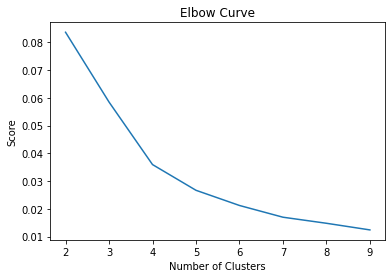

In [30]:
import matplotlib.pyplot as plt

K_clusters = range(2,10)
kmeans = [KMeans(n_clusters=i) for i in K_clusters]

score = [kmeans[i].fit(toronto_clustering).inertia_ for i in range(len(kmeans))]


# Visualize
plt.plot(K_clusters, score)
plt.xlabel('Number of Clusters')
plt.ylabel('Score')
plt.title('Elbow Curve')
plt.show()

In [31]:
from sklearn.metrics import silhouette_score
for i in range(2,9):
  kmeans_ = KMeans(n_clusters=i).fit(toronto_clustering)
  labels_ = kmeans_.labels_
  coef = silhouette_score(toronto_clustering,labels_)
  
  print("N_cluster: {}, score: {}".format(i,coef))

N_cluster: 2, score: 0.6809346754387441
N_cluster: 3, score: 0.5595841027523044
N_cluster: 4, score: 0.5848603318128476
N_cluster: 5, score: 0.597987011304821
N_cluster: 6, score: 0.5341673827459119
N_cluster: 7, score: 0.5353766697380604
N_cluster: 8, score: 0.5130992104385677


In [32]:
n_clusters_= 5

kmeans = KMeans(n_clusters = n_clusters_,random_state=0).fit(toronto_clustering)
cluster_labels = kmeans.labels_
#df5.insert(0, 'Cluster Labels', kmeans.labels_)

    

### Clustering using Hierarchical

In [43]:
from sklearn.cluster import AgglomerativeClustering
model = AgglomerativeClustering(distance_threshold=0, n_clusters=None)
model = model.fit(toronto_clustering)


In [44]:
from scipy.cluster.hierarchy import dendrogram
def plot_dendrogram(model, **kwargs):
    # Create linkage matrix and then plot the dendrogram

    # create the counts of samples under each node
    counts = np.zeros(model.children_.shape[0])
    n_samples = len(model.labels_)
    for i, merge in enumerate(model.children_):
        current_count = 0
        for child_idx in merge:
            if child_idx < n_samples:
                current_count += 1  # leaf node
            else:
                current_count += counts[child_idx - n_samples]
        counts[i] = current_count

    linkage_matrix = np.column_stack([model.children_, model.distances_,
                                      counts]).astype(float)

    # Plot the corresponding dendrogram
    dendrogram(linkage_matrix, **kwargs)

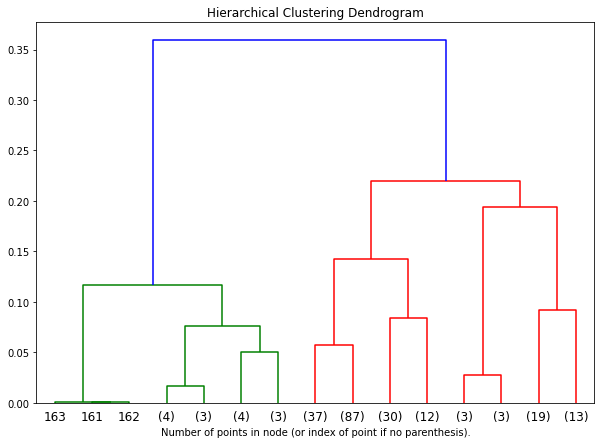

In [45]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 7))
plt.title('Hierarchical Clustering Dendrogram')
# plot the top three levels of the dendrogram
plot_dendrogram(model, truncate_mode='level', p=3)
plt.xlabel("Number of points in node (or index of point if no parenthesis).")
plt.show()

In [46]:
n_clusters_ = 4
cluster = AgglomerativeClustering(n_clusters=n_clusters_, affinity='euclidean', linkage='ward')
cluster_labels = cluster.fit_predict(toronto_clustering)
#df5.insert(0, 'Cluster Labels',cluster_labels)

In [47]:
data = toronto_clustering.iloc[:,0:3].values

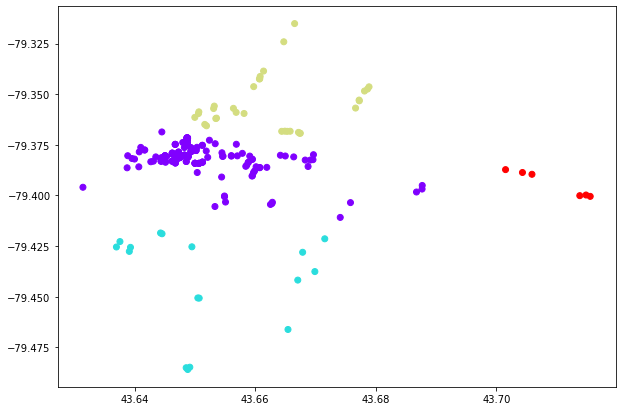

In [48]:
#data = toronto_clustering.values([0])
plt.figure(figsize=(10, 7))
plt.scatter(data[:,0], data[:,1], c=cluster.labels_, cmap='rainbow')

### Clustering using DBSCAN

In [ ]:
from sklearn.cluster import DBSCAN
from sklearn.preprocessing import StandardScaler
X = StandardScaler().fit_transform(toronto_clustering)
db = DBSCAN(eps=0.4, min_samples=6).fit(X)
core_samples_mask = np.zeros_like(db.labels_, dtype=bool)
core_samples_mask[db.core_sample_indices_] = True
cluster_labels = db.labels_
# Number of clusters in labels, ignoring noise if present.
n_clusters_ = len(set(cluster_labels)) - (1 if -1 in cluster_labels else 0)
n_noise_ = list(cluster_labels).count(-1)

In [ ]:
n_clusters_


2

In [ ]:
from sklearn.metrics import silhouette_samples, silhouette_score
silhouette_avg = silhouette_score(X, cluster_labels)
print("For n_clusters =", n_clusters_,"The average silhouette_score is :", silhouette_avg)

For n_clusters = 2 The average silhouette_score is : 0.3218386538859707


### Inserting Labels

In [49]:
#df5.insert(0, 'Cluster Labels', kmeans.labels_)
df5.insert(0, 'Cluster Labels',cluster_labels)

In [50]:
df5.head()


,Cluster Labels,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,2,"Regent Park, Harbourfront",43.65426,-79.360636,Roselle Desserts,43.653447,-79.362017,Bakery
1,2,"Regent Park, Harbourfront",43.65426,-79.360636,Tandem Coffee,43.653559,-79.361809,Coffee Shop
4,2,"Regent Park, Harbourfront",43.65426,-79.360636,Impact Kitchen,43.656369,-79.356980,Restaurant
12,2,"Regent Park, Harbourfront",43.65426,-79.360636,Rooster Coffee,43.651900,-79.365609,Coffee Shop
13,2,"Regent Park, Harbourfront",43.65426,-79.360636,Arvo,43.649963,-79.361442,Coffee Shop


### Number of Coffe Shops by Clusters 

In [35]:
df6 = df5.groupby('Cluster Labels')['Venue Category'].count()

In [36]:
df6.head()

Cluster Labels
0     30
1     20
2    156
3      6
4      9
Name: Venue Category, dtype: int64

### Creating map 


In [51]:
# create map
map_clusters = folium.Map(location=[43.651070,-79.347015],zoom_start=10)

# set color scheme for the clusters
k= n_clusters_
x = np.arange(k)
ys = [i + x + (i*x)**2 for i in range(k)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]
print(len(rainbow))
# add markers to the map
markers_colors = []
for lat, lon, neighbourhood, cluster in zip(df5['Venue Latitude'], df5['Venue Longitude'], df5['Neighborhood'], df5['Cluster Labels']):
    label = folium.Popup(' Cluster ' + str(cluster), parse_html=True)
    #print(cluster)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

4
